In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from datetime import datetime
import scipy
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, splev, CubicSpline, splprep
from scipy.signal import savgol_filter
from IPython.display import clear_output
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import shutil
%matplotlib inline
from scipy.interpolate import UnivariateSpline
import tkinter
from tkinter import filedialog
from scipy.stats import norm

In [490]:
class Processing():
    log = []
   
    sample_thickness = 38
    sample_area = 9.25
    n = 1
    m = 'all'
    method = 'adi'
    folders = []
    
    smoothen  = str()
    fit_kind = str()
    
    folder_path = 'C://Users//Enric ST//Desktop//Results//MLCs of PST//MLC_1_2_4//PE_data_adiabatic/'
    
    folder_name = 'MLC_1_2_4_160V_350K_290K'
    
    data_path = f'{folder_path}{folder_name}/'
    
    if method == 'adi':
        
        folders = ['Raw data', 'Column filter', 'Q1s', 'Fitted Q1s', 'P(E) matrix', 'P(T) matrix', 'P(S) matrix', 'dP_dS', 'delta T']
        
    if method == 'iso':
        
        folders = ['Raw data', 'Column filter', 'Q1s', 'Fitted Q1s', 'P(E) matrix', 'P(T) matrix', 'dP_dT', 'delta S']
        
        
    directories = []
    maxes = []
    lengths = []
    points = 500
    used_temps = []
    
    lowest_max_E = 0
    
    filenames = glob.glob(f'{data_path}*.tab')
    
    if m == 'all' or m >= len(filenames) or m == None:
        m = len(filenames)
    
    
    def create_folder(self, name):
        new_folder_path = self.data_path + f'{name}/'
        self.log.append(f'Creating folder {name}')
        if not os.path.isdir(new_folder_path):
            os.mkdir(new_folder_path)
            
        self.directories.append(new_folder_path)
        self.log.append(f'New folder created. Path {new_folder_path}')
   
    def create_dirs(self):
        
        for folder in self.folders:
            self.create_folder(folder)
            
        self.filenames = glob.glob(f'{self.data_path}*.tab')
        [shutil.move(i, self.directories[0]) for i in self.filenames]
        self.filenames = glob.glob(f'{self.directories[0]}*.tab')
        self.filenames = sorted(self.filenames)
        
        if self.m == 'all' or self.m >= len(self.filenames) or self.m == None:
            m = len(self.filenames)
    
    def mask_list_gen(self):
        
        # self.just_names = []
        self.mask_list = []
        self.mask_list_numbers = []
        
        self.just_names = os.listdir(self.directories[0])
        
        for name in self.just_names:
            if name.endswith('.csv'):
                self.mask_list.append(name.replace('.csv',''))
                self.mask_list_numbers.append(float(name.replace('.csv','')))
            if name.endswith('.tab'):
                self.mask_list.append(name.replace('.tab',''))
                self.mask_list_numbers.append(float(name.replace('.tab','')))
        
        self.mask_list = sorted(self.mask_list)
        self.mask_list_numbers = sorted(self.mask_list_numbers)
        
    def filing_shenanigans(self):
        print('Reorganising files')
        self.create_dirs()
        self.mask_list_gen()
        if len(self.directories) == 0:
            self.filenames = sorted(glob.glob({self.directories}+'*.tab'))
        else:
            self.create_dirs()
        self.log.append('Folders created, files reassigned.')
        self.m = len(self.filenames)
        print('Files reorganised')
        
    def check_empties(self):
        print('Checking dataset for empty files:')
        self.log.append('check_empties_initiated')
        self.empties = []
        self.empties_index = []
        
        for i, dataset in enumerate(self.filenames):
            if pd.read_table(dataset).empty:
                self.empties.append(self.mask_list[i])
                self.empties_index.append(i)
                self.log.append(f'Empty file detected: {self.mask_list[i]}')
                
        if len(self.empties) != 0:
            print (f'Empty files detected: {self.empties}')
        else:
            self.log.append('No empty files detected')
            print('No empty files detected')
            
    def remove_empties(self):
        clear_output(wait=True)
        print('Removing empty files:')
        if len(self.empties) != 0:
            for i in self.empties_index:
                removal_candidate = self.mask_list[i]
                self.log.append(f'Removing file {removal_candidate} from mask_list')
                del self.mask_list[i]
                self.log.append(f'Removing file {removal_candidate} from mask_list_numbers')
                del self.mask_list_numbers[i]
                self.log.append(f'Removing file {removal_candidate} from filenames')
                del self.filenames[i]
        print('All empty fils removed')
        
    def column_filter(self, dataset, output_name):
        
        file = pd.read_table (dataset)
        
        self.maxes.append(max(file['#Drive Voltage']))
        self.lengths.append(len(file))
                
        file.drop(['E_SI', 'P_SI','Point','Time (ms)'], axis = 1, inplace = True)
                
        file.insert(0, 'E_field (kV/cm)', (10**-5*file['#Drive Voltage']/\
                                                (self.sample_thickness*10**-6))) #field in kV/cm      
        file.drop(['#Drive Voltage'], axis = 1, inplace = True)
                
        file['Measured Polarization'] = 10**-6*file['Measured Polarization']/\
                (self.sample_area*10**-4)# normalising polarisation by sample ares in cm^2
                
        file.insert(1, 'Measured Polarization (C/m^2)', (file['Measured Polarization']))
        file.drop(columns = ['Measured Polarization'], inplace = True)
                
        file.to_csv(self.directories[1] + '/' + output_name + '.csv')
        return file
        
    def E_max_finder(self):
        maxes = []
        lengths = []
        
        self.log.append('Finding min E_max')
        
        for i in self.filenames[0:self.m]:
        
            file = pd.read_table (i)
                
            maxes.append(10**-5*max((file['#Drive Voltage'])/(self.sample_thickness*10**-6)))
            lengths.append(len(file))
        
        self.lowest_max_E = min(maxes)
        self.lowest_length = min(lengths)
        self.log.append(f'Lowest max E_field = {self.lowest_max_E}')
    
    def Q1_select(self, file, output_name):
        
        self.log.append(f'Resolving Q1 for file {output_name}')
        
        Q1 = file.iloc[(file['E_field (kV/cm)'].idxmax()):(file['E_field (kV/cm)'].idxmin()),:]
        
        Q1 = Q1[(Q1['E_field (kV/cm)'] > 0)]
        Q1 = Q1[(Q1['Measured Polarization (C/m^2)'] > 0)]
        Q1_field = Q1['E_field (kV/cm)']
        # Q1_field = Q1['E_field (kV/cm)'] - min(Q1['E_field (kV/cm)'])
        Q1_polarisation = Q1['Measured Polarization (C/m^2)']
    
        Q1 = Q1.iloc[::-1]    
        Q1.to_csv(f'{self.directories[2]}/{output_name}.csv')
        
        return Q1, Q1_field, Q1_polarisation
        
    def data_sim(self, x_data, y_data, output_name, smooth = None, fit_kind = 'cubic'):
        
        if not smooth:
            smooth = self.smoothen
        if not fit_kind:
            fit_kind = self.fit_kind
        
        fitting_Q1 = pd.DataFrame()
        
        if fit_kind == 'cubic':
            
            fit = interp1d(x_data, y_data, kind = 'cubic', fill_value = 'extrapolate', bounds_error = False)
        else:
            fit = interp1d(x_data, y_data, kind = 'linear', fill_value = 'extrapolate', bounds_error = False)
        
        y_sim = fit(self.x_sim)
        
        fitting_Q1.insert(0, 'Fitted E_field (kV/cm)', self.x_sim)
        fitting_Q1.insert(1,'Fitted Polarisation (C/m^2)', y_sim)
      
        fitting_Q1.to_csv(f'{self.directories[3]}/{output_name}.csv')
        
        return y_sim

    def ST_file_process(self):
        
        self.log.append('ST_process_initiated')
        
        ST = pd.read_csv('C://Users/Enric ST//Desktop//Results//MLCs of PST//41586_2019_1634_MOESM2_ESM.csv')
        
        self.log.append('ST file imported')
        
        ST.drop(ST[ST['Electric-field (V m-1)'] > 0].index, inplace = True)
        ST.drop('Electric-field (V m-1)', axis = 1, inplace = True)
        ST.drop(ST[ST['Temperature (K)'] > max(self.mask_list_numbers)].index, inplace = True)
        ST.drop(ST[ST['Temperature (K)'] < min(self.mask_list_numbers)].index, inplace = True)
        ST.insert(0, 'Entropy (kJ K-1 m-3)', ((10**-3)*(ST['Entropy (J K-1 m-3)']-ST.iloc[0,1])))
        ST.drop(['Entropy (J K-1 m-3)'], axis = 1, inplace = True)
        
        self.log.append('ST_file processed for current analysis')
        
        T_sim = np.linspace(self.used_temps[0], self.used_temps[-1], len(self.used_temps))
        
        x_data  = ST['Temperature (K)']
        y_data = ST['Entropy (kJ K-1 m-3)']
        fit = interp1d(x_data, y_data, kind = 'cubic', fill_value = 'extrapolate', bounds_error = False)
        ST_sim = fit (T_sim)
        
        self.log.append('ST_data simulated')
        
        self.ST = ST
        self.ST_raw_TS = [x_data,y_data]
        self.ST_sim = [T_sim,ST_sim]
        
    def initial_processing(self):
        
        self.Q1_bits = [[],[],[]]
        self.used_temps = []
        P_max = []
        self.Q1s = []
        clear_output(wait = True)
        print('Finding lowest E_max:')
        # if self.lowest_max_E != 0:
        self.E_max_finder()
        self.log.append(f'Simulation points {self.points}')
        self.log.append(f'Maximum electric field for simulation = {self.lowest_max_E}')
        clear_output(wait = True)
        print(f'Maximum E_field for simulation = {(np.round(self.lowest_max_E, 2))} kV/cm')
        
        self.x_sim = np.linspace(0, 0.999*self.lowest_max_E, self.points)
            
        self.log.append(f'Processing first {self.m} files')
            
        for i, dataset in enumerate(self.filenames[:self.m]):
            
            
            if i % self.n != 0:
                continue
            else:
                clear_output(wait = True)
                
                self.log.append(f'Processing file {self.mask_list[i]}.')
            
                file = self.column_filter(dataset, self.mask_list[i])
                self.log.append(f'Column filter applied to  {self.mask_list[i]}.')
                
                    
                Q1, Q1_field, Q1_polarisation = self.Q1_select(file, self.mask_list[i])
                self.Q1s.append(Q1)
                self.Q1_bits[0].append(Q1_field)
                self.Q1_bits[1].append(Q1_polarisation)
                P_max.append(max(Q1_polarisation))
                self.log.append(f'Q1_select applied to  {self.mask_list[i]}.')
                    
                y_sim = self.data_sim(Q1_field, Q1_polarisation, self.mask_list[i], self.smoothen, self.fit_kind)
                    
                self.Q1_bits[2].append(y_sim)
                    
                self.log.append(f'File  {self.mask_list[i]} processed successfully.')
                self.used_temps.append(self.mask_list_numbers[i])
                
        self.P_max = max(P_max)
    
    def plot_individual_PE(self, i, type = 'full', data = False, sims = False):
        
        if i > len(self.filenames) or i < 0:
            raise ValueError(f'selected i is outside of range. Select value between 0 and {len(self.filenames)}')
        
        fig, ax = plt.subplots(figsize = (20,13))
        plt.ylabel ('Measured Polarisation (C m$^{-2}$)', fontsize=30)
        plt.xlabel ('Applied field (kV cm$^{-1}$)', fontsize=30)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.axhline(0, c = 'k', ls = '--')
        plt.axvline(0, c = 'k', ls = '--')
        
        file = self.column_filter(self.filenames[i], self.mask_list[i])
        if type == 'just_Q1':
            data = True
            Q1, Q1_field, Q1_polarisation = self.Q1_select(file, self.mask_list[i])
            y_sim = self.data_sim(Q1_field, Q1_polarisation, self.mask_list[i], self.smoothen, self.fit_kind)
            
        print(f'T = {self.mask_list_numbers[i]} K')
        
        if type =='full':
             plt.plot(file['E_field (kV/cm)'], file['Measured Polarization (C/m^2)'])
        if type == 'just_Q1' and data == True:
            plt.plot(Q1_field, Q1_polarisation, '-')
        if type == 'just_Q1' and sims == True:
            plt.plot(self.x_sim, y_sim,  'r--');
    
    def assemble_PE_matrix (self):
        
        self.log.append(f'Assembling P(E) matrix using {len(self.used_temps)} files in the range {min(self.used_temps)} - {max(self.used_temps)}')
        
        PE_matrix = pd.DataFrame ()
        Q1_bits_2 = []
        
        for i in self.Q1_bits[2]:
            Q1_bits_2.append(pd.Series(i))
        
        PE_matrix = pd.concat(Q1_bits_2, axis = 1)
        PE_matrix.columns = self.used_temps
        PE_matrix.insert(0, 'Fitted E_field (kV/cm)', self.x_sim)

        self.PE_matrix = PE_matrix
        
        self.log.append('P(E) matrix assembled successfully')
            
        self.PE_matrix.to_csv(self.directories[4] + '/' + 'P(E) matrix' + '.csv')
        print('P(E) matrix assembled and saved')
        self.log.append('P(E) matrix saved')
    
    def PE_transpose (self):
        
        clear_output(wait = True)
        
        self.log.append('Assembling PT matrix')
        
        print('Transposing PE matrix')
        
        PT_matrix = self.PE_matrix.set_index('Fitted E_field (kV/cm)').T
        self.PT_matrix = PT_matrix
        PT_matrix.to_csv(f'{self.directories[5]}/P(T) matrix.csv')
        self.log.append('PT matrix assembled and saved')
        print('PT matrix assembled and saved')    
  
    def PT_matrix_diff(self, smooth = False, sm_window = 11):
        
        PT_matrix = self.PT_matrix
        self.log.append('Differentiating P(S) matrix')
        
        dT = np.diff(PT_matrix.index)
        dPdTs = []
        
        for i in range(len(PT_matrix.columns)):
                
            clear_output(wait = True)
            
            print('Differentiation P(T) matrix wrt T ', (np.round(100*((i+1)/len(PT_matrix.columns)), 2)), '%')
            
            dP = pd.Series(np.diff(PT_matrix.iloc[:,i]))
            dPdTs.append(dP/dT)
            
            if smooth == True:
                dP = savgol_filter(dP,sm_window,3)
                
        dP_dT = pd.concat(dPdTs, axis  = 1)
        dP_dT.columns = PT_matrix.columns
        dP_dT.index =  PT_matrix.index[:-1]
        self.dP_dT = dP_dT
        
        self.log.append('dP_dT matrix assembled and saved sucessfully')
        print('dP_dT matrix assembled and saved sucessfully')
    
    def PS_substitution(self):
        
        self.log.append('Assembling P(S) matrix')
        clear_output(wait = True)
        print('Assembling PS dataset')
        
        PS_matrix = self.PT_matrix.copy()
        
        PS_matrix.index = self.ST_sim[1]
        self.PS_matrix = PS_matrix
        self.PS_matrix.to_csv(f'{self.directories[6]}/P(S) matrix.csv')
        
        self.log.append('P(S) matrix assembled and saved')

        print('P(S) matrix assembled and saved')
        
    def PS_matrix_diff(self, smooth = False, sm_window = 11):
        PS_matrix = self.PS_matrix
        
        self.log.append('Differentiating P(S) matrix')
        
        dS = np.diff(self.ST_sim[1])
        
        dPdSs = []
        
        for i in range(len(PS_matrix.columns)):
            
            clear_output(wait = True)
            
            print('Differentiation P(S) matrix wrt S ', (np.round(100*((i+1)/len(PS_matrix.columns)), 2)), '%')
            
            dP = pd.Series(np.diff(PS_matrix.iloc[:,i]))
            
            if smooth == True:
                dP = savgol_filter(dP,sm_window,3)
               
            dPdSs.append(pd.DataFrame(dP/dS))
            
        dP_dS = pd.concat(dPdSs, axis  = 1)
        dP_dS.index = self.ST_sim[1][:-1]
        dP_dS.columns = self.PS_matrix.columns

        self.dP_dS = dP_dS  
         
        dP_dS.to_csv(self.directories[7] + 'dP_dS.csv') 
        self.log.append('dP_dS matrix assembled and saved sucessfully')
        print('dP_dS matrix assembled and saved sucessfully')
    
    def PS_integration(self):
        
        integrals = []
        length = len(self.dP_dS)
        
        for i in range(length):
            
            clear_output(wait = True)
            
            print('dP/dS matrix integration wrt E: ', (np.round(100*((i+1)/length), 2)), '%')
            
            x = self.dP_dS.columns
            y = self.dP_dS.iloc[i,:]
            
            y_integral = -100*scipy.integrate.cumtrapz(y, x, initial = 0)
            integrals.append(pd.Series(y_integral))
            PS_integral = pd.concat(integrals, axis = 1)
            
        PS_integral.index = self.x_sim

        PS_integral.columns = self.dP_dS.index

        self.PS_integral = PS_integral
        
        PS_integral.to_csv(f'{self.directories[8]}/Delta T.csv')
        
        self.log.append('delta_T dataset assembled and saved')
        print('Delta T dataset generated and saved')
     
    def plot_PE_loops(self, n = 1, range_start = 0, range_end = int, legend = False, data = False, sims = False, first = False, last = False, specific = []):
        
        fig, ax = plt.subplots(figsize = (20,13))
        
        if range_end >= len(self.used_temps):
            range_end = len(self.used_temps)
            last = True
        else:
            range_end = range_end
            
        if n >= 1:
            n = np.round(n)
        else:
            n = 1
        
        plt.xlim(0, self.lowest_max_E)
        plt.ylim(0, 1.25*self.P_max)
        plt.ylabel ('Measured Polarisation (C m$^{-2}$)', fontsize=30)
        plt.xlabel ('Applied field (kV cm$^{-1}$)', fontsize=30)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.axhline(0, c = 'k', ls = '--')
        plt.axvline(0, c = 'k', ls = '--')
        
        if data == True and range_start != 0 and first == True:
            plt.plot(self.Q1_bits[0][0], self.Q1_bits[1][0], '-',label = ('$T$ = ' + str(self.used_temps[0])+' K'))
            
        if sims == True and range_start != 0 and first == True:
            plt.plot(self.x_sim, self.Q1_bits[2][0], '-',label = ('$T$ = ' + str(self.used_temps[0])+' K'))
            
        
        for i in specific:
            if i < range_start and data == True:
                plt.plot(self.Q1_bits[0][i], self.Q1_bits[1][i], '-',label = (f'$T$ = {self.used_temps[i]} K'))
                
            if i < range_start and sims == True:
                plt.plot(self.x_sim, self.Q1_bits[2][i], '-',label = (f'$T$ = {self.used_temps[i]} K'))

        for i in range(range_start, range_end):
            
            if i % n == 0:
                if data == True:
                    plt.plot(self.Q1_bits[0][i], self.Q1_bits[1][i], '-',label = (f'$T$ = {self.used_temps[i]} K'))
                
                if sims == True:
                    plt.plot(self.x_sim, self.Q1_bits[2][i],  '-',   label = (f'$T$ = %.2f K' %self.used_temps[i]))
        
        for i in specific:
            if i > range_end and data == True:
                plt.plot(self.Q1_bits[0][i], self.Q1_bits[1][i], '-',label = (f'$T$ = {self.used_temps[i]} K'))
            if i > range_end and sims == True:
                plt.plot(self.x_sim, self.Q1_bits[2][i], '-',label = (f'$T$ = {self.used_temps[i]} K'))
    

        if data == True and range_end < len(self.used_temps) and last == True:
            plt.plot(self.Q1_bits[0][-1], self.Q1_bits[1][-1], '-',label = (f'$T$ = {self.used_temps[-1]} K'))
        
        if sims == True and range_end < len(self.used_temps) and last == True:  
            plt.plot(self.x_sim, self.Q1_bits[2][-1], '-',label = (f'$T$ = {self.used_temps[-1]} K'))
        
        if legend == True:
            plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., prop={"size":30});
            
    def plot_PT_data(self, n = 1, range_start = 0, range_end = 'full', first = False, last = False, legend = False, specific = []):
        
        
        PT_matrix = self.PT_matrix
        length = len(PT_matrix.columns)
        
        if range_end == 'full':
            range_end = length
        
        if n >= 1:
            n = np.round(n)
        else:
            n = 1
            
        if range_end > length or range_end <= range_start:
            range_end = length
        
        if range_start < 0 or range_start >= range_end:
            range_start = 0
            
        
        fig, ax = plt.subplots(figsize = (20,13))
        
        plt.ylabel ('Measured polarisation (C m$^{-2}$)', fontsize=30)
        plt.xlabel ('Temperature (K)', fontsize=30)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        
        if range_start != 0 and first == True:
            
            plt.plot(PT_matrix.index, PT_matrix.iloc[:,0], label = ('E  = %.2f kV cm$^{-1}$'  %PT_matrix.columns[0]))
            
        for i in specific:
            if i < range_start and i > 0:
                plt.plot(PT_matrix.index, PT_matrix.iloc[:,i], label = ('E  = %.2f kV cm$^{-1}$'  %PT_matrix.columns[i]))
        
        for i in range(range_start, range_end):
            
            if i % n == 0:
                plt.plot(PT_matrix.index, PT_matrix.iloc[:,i], label = ('E  = %.2f kV cm$^{-1}$'  %PT_matrix.columns[i]))
                
        for i in specific:
            if i > range_end and i < length:
                plt.plot(PT_matrix.index, PT_matrix.iloc[:,i], label = ('E  = %.2f kV cm$^{-1}$'  %PT_matrix.columns[i]))
            
        if n != 1 and last == True and range_end < length:
            plt.plot(PT_matrix.index, PT_matrix.iloc[:,-1], label = ('E  = %.2f kV cm$^{-1}$'  %PT_matrix.columns[-1]))
            
        if legend == True:
            plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., prop={"size":30})
            
    def plot_dP_dT_matrix(self, n = 3,range_start = 1, range_end = 'full', first = False, last = False, legend = False, specific = []):
        
        self.log.append('Plotting dP_dT data')
        
        dP_dT = self.dP_dT
        length = len(dP_dT.columns)
        
        if range_end == 'full':
            range_end = length
        
        if n >= 1:
            n = np.round(n)
        else:
            n = 1
            
        if range_end > length or range_end <= range_start:
            range_end = length
        
        if range_start < 0 or range_start >= range_end:
            range_start = 0
        
        fig, ax = plt.subplots(figsize = (20,13))
        
        plt.ylabel ('d$P$/d$T$ (C m$^{-2}$ K$^{-1}$)',fontsize=30)
        plt.xlabel ('Temperature (K)',fontsize=30)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        
        if n != 1 and first == True and range_start > 0:
            plt.plot(dP_dT.index, dP_dT.iloc[:,0], '-',label = ('$E$ = %.2f $kV$ $cm^{-1}$' %dP_dT.columns[0]))
            
        for i in specific:
            if i < range_start and i > 0:
                plt.plot(dP_dT.index, dP_dT.iloc[:,i], '-',label = ('$E$ = %.2f $kV$ $cm^{-1}$' %dP_dT.columns[i]))
        
        for i in range(range_start, range_end):
            
            if i % n == 0:
                plt.plot(dP_dT.index, dP_dT.iloc[:,i], '-',label = ('$E$ = %.2f $kV$ $cm^{-1}$' %dP_dT.columns[i]))
                
        for i in specific:
            if i > range_end and i < length:
                plt.plot(dP_dT.index, dP_dT.iloc[:,i], '-',label = ('$E$ = %.2f $kV$ $cm^{-1}$' %dP_dT.columns[i]))
                
        if n != 1 and last == True and range_end < length:
            plt.plot(dP_dT.index, dP_dT.iloc[:,-1], '-',label = ('$E$ = %.2f $kV$ $cm^{-1}$' %dP_dT.columns[-1]))
                
        if legend == True:
            plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., prop={"size":30});
                
        self.log.append('dP_dT data plotted') 
    
    def plot_PS_matrix(self, n = float, range_start = 0, range_end = 'full', first = False, last = False, legend = False, specific = []):
        
        PS_matrix = self.PS_matrix
        length = len(PS_matrix.columns)
        
        if range_end == 'full':
            range_end = length
        
        if n >= 1:
            n = np.round(n)
        else:
            n = 1
            
        if range_end > length or range_end <= range_start:
            range_end = length
        
        if range_start < 0 or range_start >= range_end:
            range_start = 0
            
        fig, ax = plt.subplots(figsize = (20,13))

        plt.ylabel ('Measured Polarisation (C m$^{-2}$)', fontsize=30)
        plt.xlabel ('$S^{‎\prime}$ (kJ K$^{-1}$ m$^{-3}$)', fontsize=30)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        
        if range_start != 0 and first == True:
            plt.plot (PS_matrix.index, PS_matrix.iloc[:,0], label = ('E  = %.2f kV cm$^{-1}$'  %PS_matrix.columns[0]))
            
        for i in specific:
            if i < range_start and i >= 0:
                plt.plot(PS_matrix.index, PS_matrix.iloc[:,i], label = ('E  = %.2f kV cm$^{-1}$'  %PS_matrix.columns[i]))

        for i in range(range_start, range_end):
            if i % n == 0:
                plt.plot (PS_matrix.index, PS_matrix.iloc[:,i], label = ('E  = %.2f kV cm$^{-1}$'  %PS_matrix.columns[i]))
                
        for i in specific:
            if i > range_end and i < length:
                plt.plot(PS_matrix.index, PS_matrix.iloc[:,i], label = ('E  = %.2f kV cm$^{-1}$'  %PS_matrix.columns[i]))
                
        if range_end < length and last == True:
            plt.plot (PS_matrix.index, PS_matrix.iloc[:,-1], label = ('E  = %.2f kV cm$^{-1}$'  %PS_matrix.columns[-1]))

        if legend == True:
            plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., prop={"size":30});
    
    def plot_dP_dS_matrix(self, n = 1, range_start = 0, range_end = 'full', first = False, last = False,  legend = False, specific = []):
        
        dP_dS = self.dP_dS
        length = len(dP_dS.columns)
        
        if range_end == 'full':
            range_end = length
        
        if n >= 1:
            n = np.round(n)
        else:
            n = 1
            
        if range_end > length or range_end <= range_start:
            range_end = length
        
        if range_start < 0 or range_start >= range_end:
            range_start = 0
            
        fig, ax = plt.subplots(figsize = (20,13))
        
        plt.ylabel ('d$P$/d$S^{‎\prime}$ (C m$^{-2}$ kJ$^{-1} $ K m$^3$)',fontsize=30)
        plt.xlabel ('$S^{‎\prime}$ (kJ K$^{-1}$ m$^{-3}$)',fontsize=30)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        
        if range_start != 0 and first == True:
            plt.plot(dP_dS.index, dP_dS.iloc[:,0], label = ('$E$ = %.2f $kV$ $cm^{-1}$' %dP_dS.columns[0]))
            
        for i in specific:
            if i < range_start and i > 0:
                plt.plot(dP_dS.index, dP_dS.iloc[:,i], label = ('$E$ = %.2f $kV$ $cm^{-1}$' %dP_dS.columns[i]))
        
        for i in range(range_start, range_end):
            if i % n == 0:
                plt.plot (dP_dS.index, dP_dS.iloc[:,i], '-', label = ('$E$ = %.2f $kV$ $cm^{-1}$' %dP_dS.columns[i]))
                
        for i in specific:
            if i > range_end and i < length:
                plt.plot(dP_dS.index, dP_dS.iloc[:,i], label = ('$E$ = %.2f $kV$ $cm^{-1}$' %dP_dS.columns[i]))
                
        if range_end < length and last == True:
            plt.plot (dP_dS.index,dP_dS.iloc[:,-1], label = ('$E$ = %.2f $kV$ $cm^{-1}$' %dP_dS.columns[-1]))
                
        if legend == True:
            plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., prop={"size":30});
    
    def plot_delta_T (self, n = 1, range_start = 0, range_end = 'full', first = False, last = False, legend = False, specific = [], x = 'vs_E'):
        
        self.log.append('Plotting delta T data')
        
        PS_integral = self.PS_integral
        length = len(PS_integral.columns)
        
        if x == 'vs_E':
            x_data = PS_integral.index
            label = PS_integral.columns
        if x == 'vs_S_dash':
            x_data = PS_integral.columns
            label = PS_integral.index
        
            
        if range_end == 'full':
            if x == 'vs_E':
                range_end = length
            if x == 'vs_S_dash':
                range_end = len(PS_integral)
            
        if n >= 1:
                n = np.round(n)
        else:
            n = 1
            print(f'Value of n was reset to {n}')
            self.log.append(f'Value of n was reset to {n}')
            
        if x == 'vs_E':
            if range_end > length or range_end <= range_start:
                range_end = length
        
        if x == 'vs_S_dash':
            if range_end > len(PS_integral) or range_end <= range_start:
                range_end = len(PS_integral)
            
        if range_start < 0 or range_start >= range_end:
            range_start = 0
        
        fig, ax = plt.subplots(figsize = (20,13))
        
        plt.ylabel ("$\Delta T$ (K)",fontsize=30)
        if x == 'vs_E':
            plt.xlabel ('Electric field (kV/cm$^{-1}$)',fontsize=30)
        if x == 'vs_S_dash':
            plt.xlabel ('$S^{‎\prime}$ (kJ K$^{-1}$ m$^{-3}$)',fontsize=30)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.axhline (0, c = 'k', ls  = '--')
        plt.axvline (0, c = 'k', ls  = '--')
        plt.xlim(0,235)
        # plt.ylim(-1,1)
        
        if range_start != 0 and first == True:
            if x == 'vs_E':
                plt.plot (x_data, PS_integral.iloc[:,0], label = ('$S^{‎\prime}$=%.2f (kJ K$^{-1}$ m$^{-3}$)' %label[0]))
            if x == 'vs_S_dash':
                plt.plot (x_data, PS_integral.iloc[0,:], label = ('$E$ = %.2f $kV$ $cm^{-1}$' %label[0]))  
            
        for i in specific:
            if i < range_start and i >= 0:
                if x == 'vs_E':
                    plt.plot(x_data, PS_integral.iloc[:,i], label = ('$S^{‎\prime}$=%.2f (kJ K$^{-1}$ m$^{-3}$)' %label[i]))
                if x == 'vs_S_dash':
                    plt.plot(x_data, PS_integral.iloc[i,:], label = ('$E$ = %.2f $kV$ $cm^{-1}$' %label[i]))
            
        for i in range(range_start, range_end):
            
            if i % n == 0:
                if x == 'vs_E':
                    plt.plot (x_data, PS_integral.iloc[:,i], label = ('$S^{‎\prime}$=%.2f (kJ K$^{-1}$ m$^{-3}$)' %PS_integral.columns[i]))
                if x == 'vs_S_dash':  
                    plt.plot(x_data, PS_integral.iloc[i,:], label = ('$E$ = %.2f $kV$ $cm^{-1}$' %label[i]))
               
        for i in specific:
                if i > range_end and i < length:
                    if x == 'vs_E':
                        plt.plot(x_data, PS_integral.iloc[:,i], label = ('$S^{‎\prime}$=%.2f (kJ K$^{-1}$ m$^{-3}$)' %PS_integral.columns[i]))
                    if x == 'vs_S_dash':
                        plt.plot(x_data, PS_integral.iloc[i,:], label = ('$E$ = %.2f $kV$ $cm^{-1}$' %label[i]))
                    
        if range_end < length and last == True:
            if x == 'vs_E':
                plt.plot (x_data, PS_integral.iloc[:,-1], label = ('$S^{‎\prime}$=%.2f (kJ K$^{-1}$ m$^{-3}$)' %PS_integral.columns[-1]))
            if x == 'vs_S_dash':
                plt.plot (x_data, PS_integral.iloc[-1,:], label = ('$E$ = %.2f $kV$ $cm^{-1}$' %label[-1]))
            
        if legend == True:
            plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.,prop={"size":30});

In [497]:
my_processing = Processing()
my_processing.filing_shenanigans()
my_processing.check_empties()
my_processing.remove_empties()
my_processing.initial_processing()
my_processing.ST_file_process()

Maximum E_field for simulation = 41.23 kV/cm


T = 297.28 K


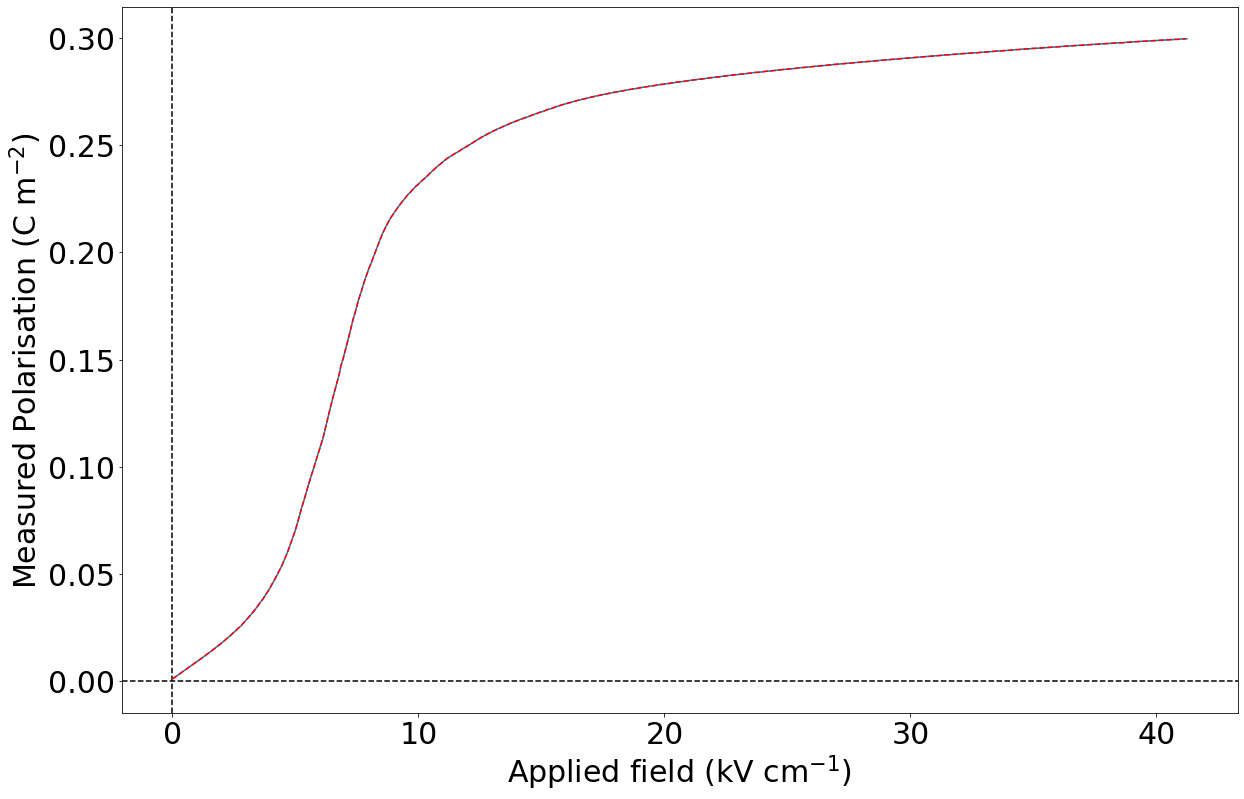

In [498]:
my_processing.plot_individual_PE(25, type = 'just_Q1', data = True, sims = True)

In [499]:
my_processing.assemble_PE_matrix()
my_processing.PE_transpose()
my_processing.PT_matrix_diff()
my_processing.PS_substitution()
my_processing.PS_matrix_diff(smooth = True, sm_window=11)
my_processing.PS_integration()

dP/dS matrix integration wrt E:  100.0 %
Delta T dataset generated and saved


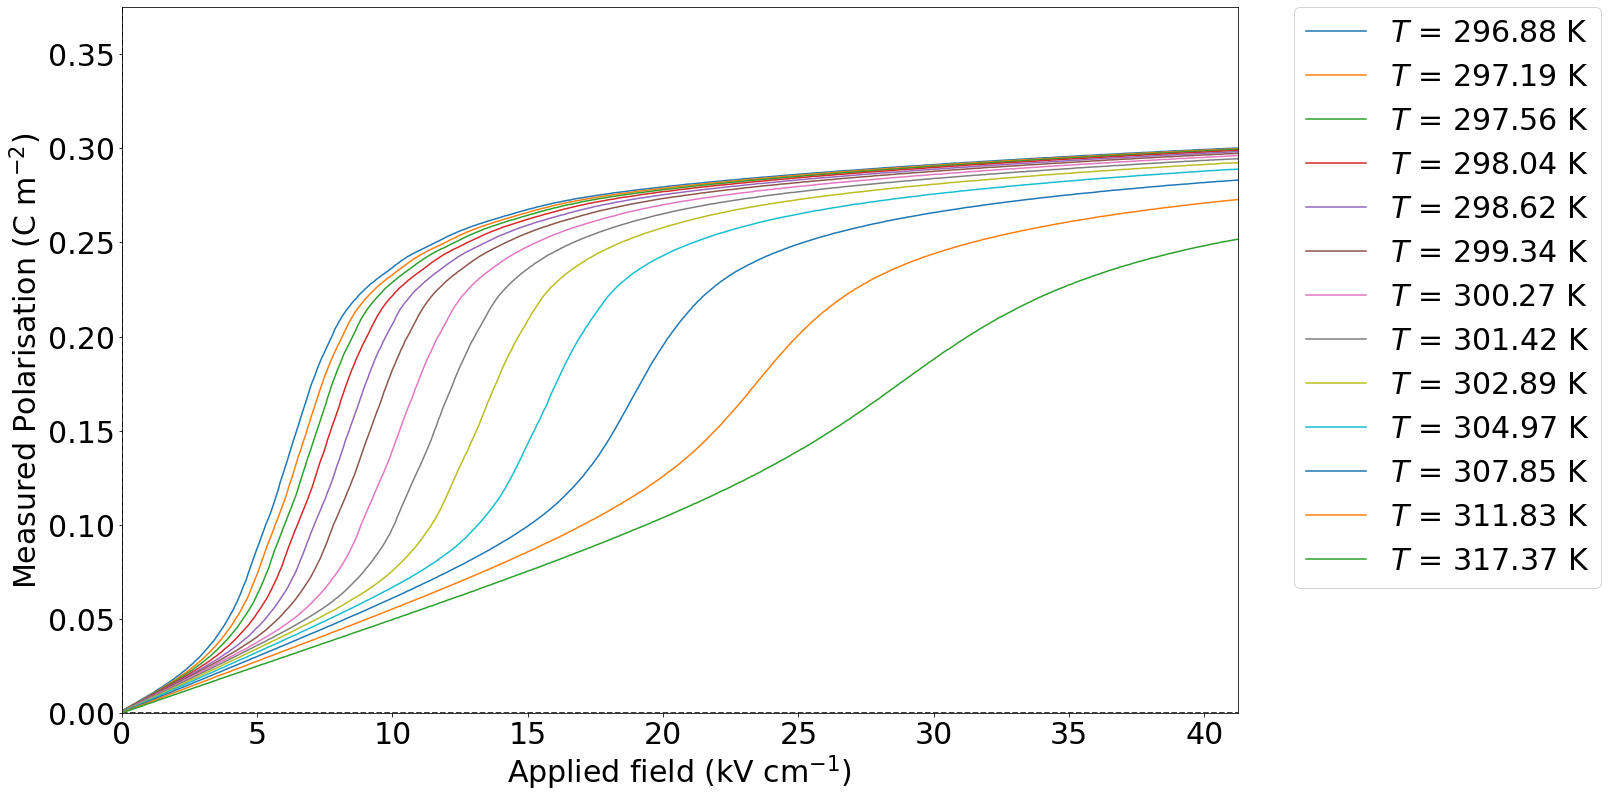

In [500]:
my_processing.plot_PE_loops(n = 20,range_start = 0, range_end=500, legend=True, last = True, data = True, sims = False)

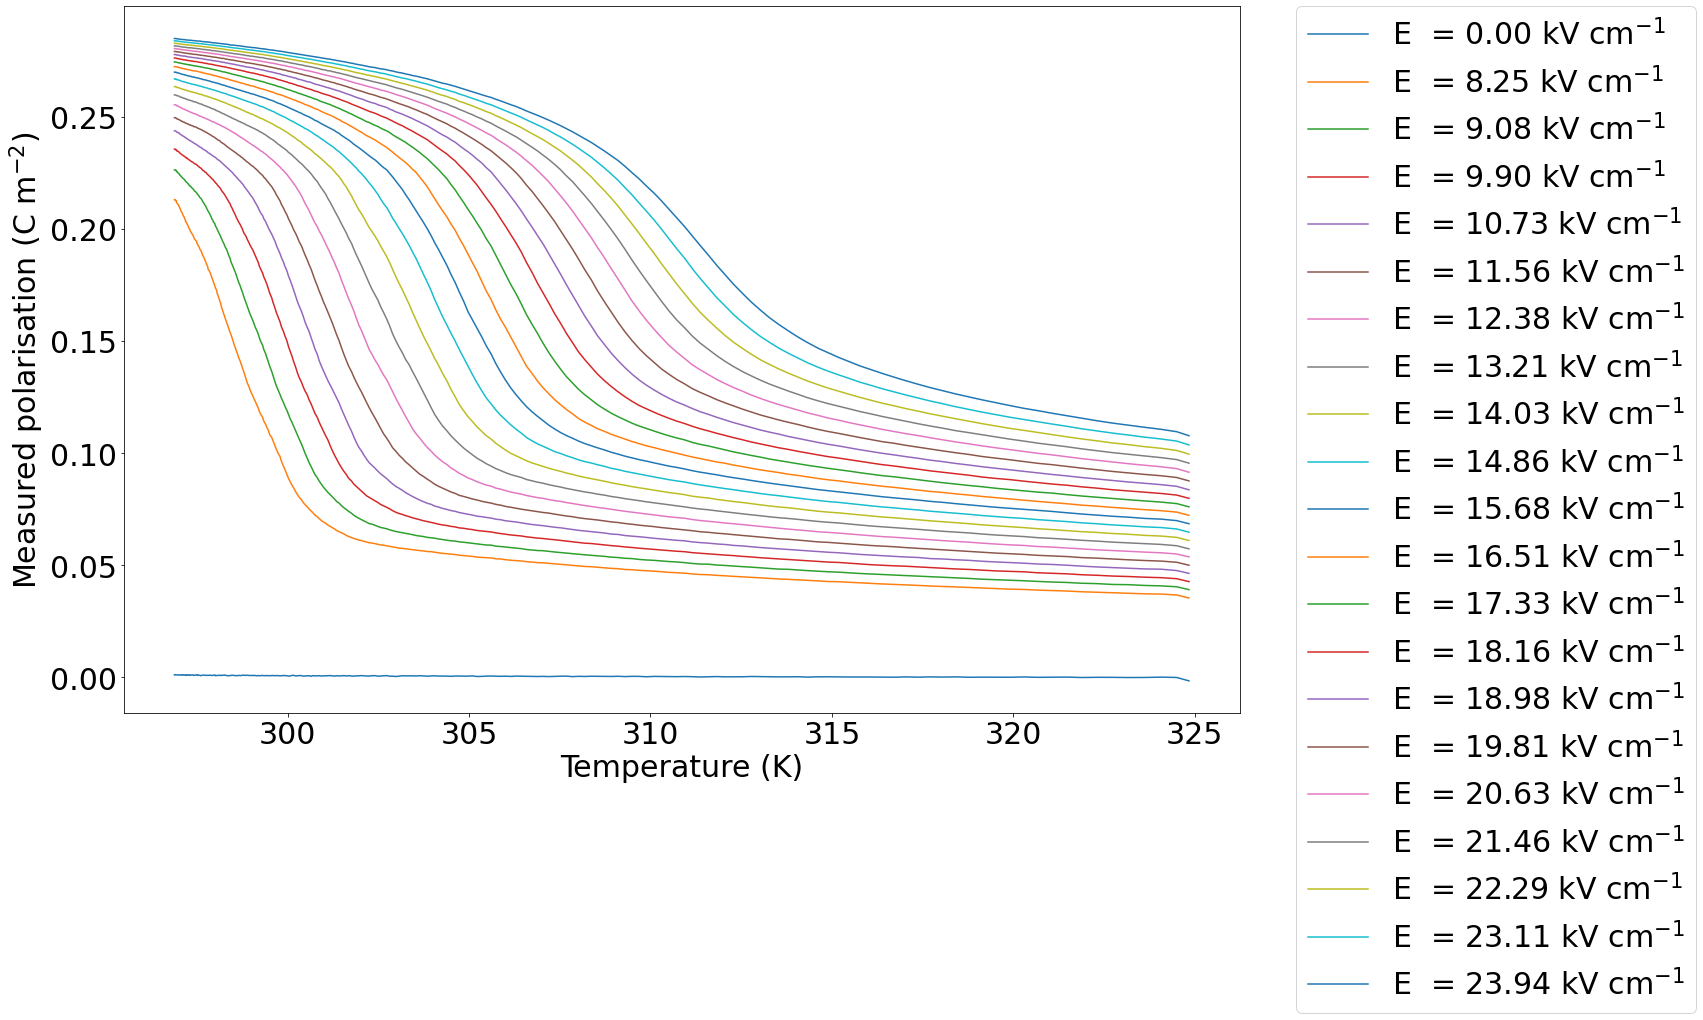

In [507]:
my_processing.plot_PT_data(range_start = 100, range_end = 300, n = 10, legend = True, first = True, last = False)

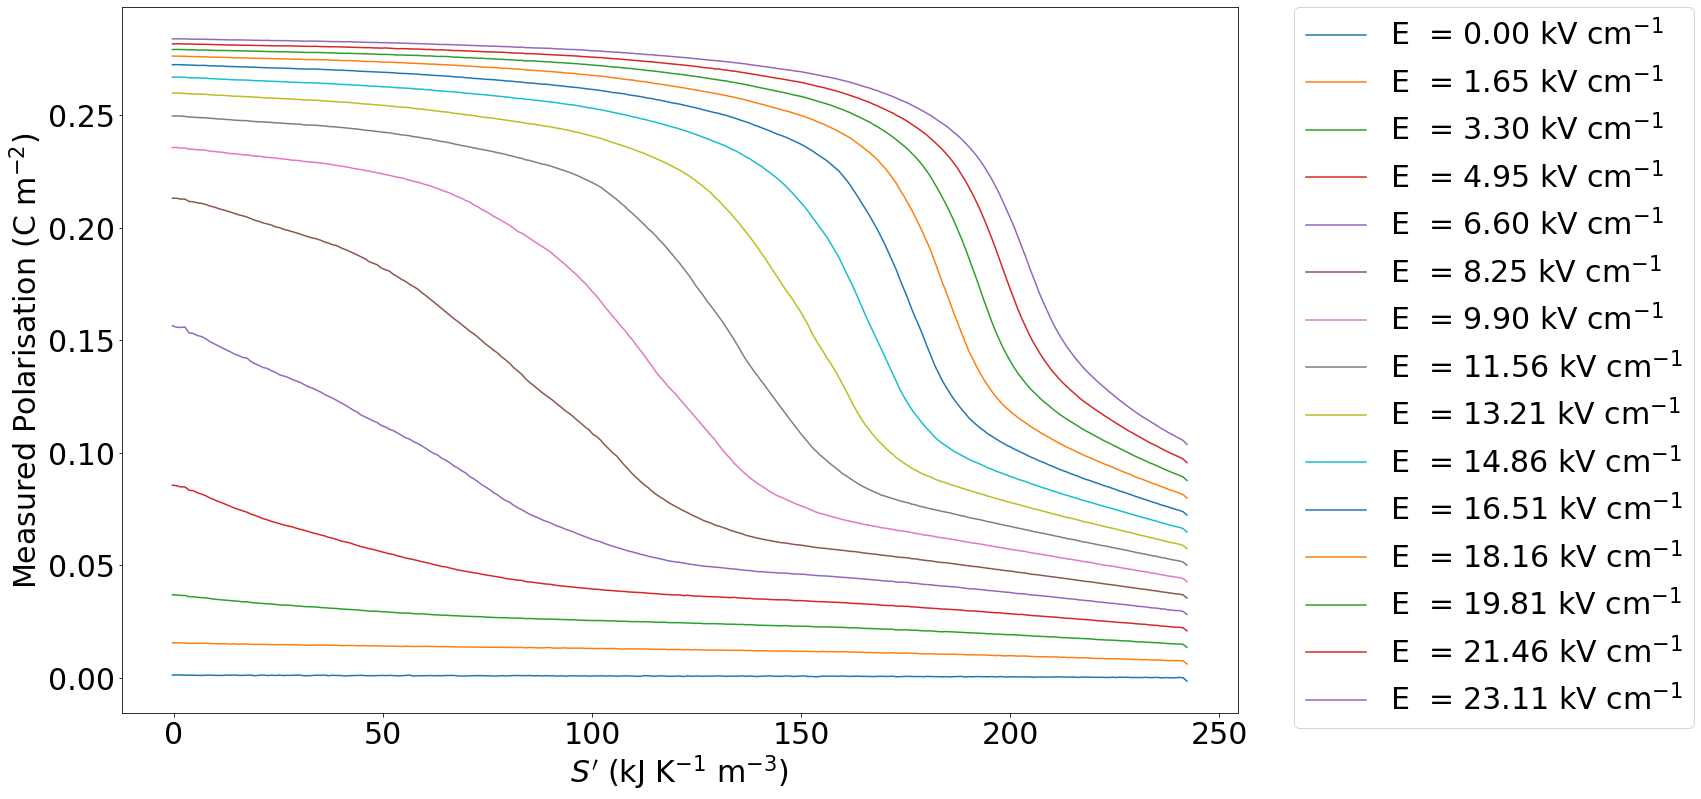

In [502]:
my_processing.plot_PS_matrix(n = 20, range_start = 0, range_end = 300, legend = True, first = False, last = False)

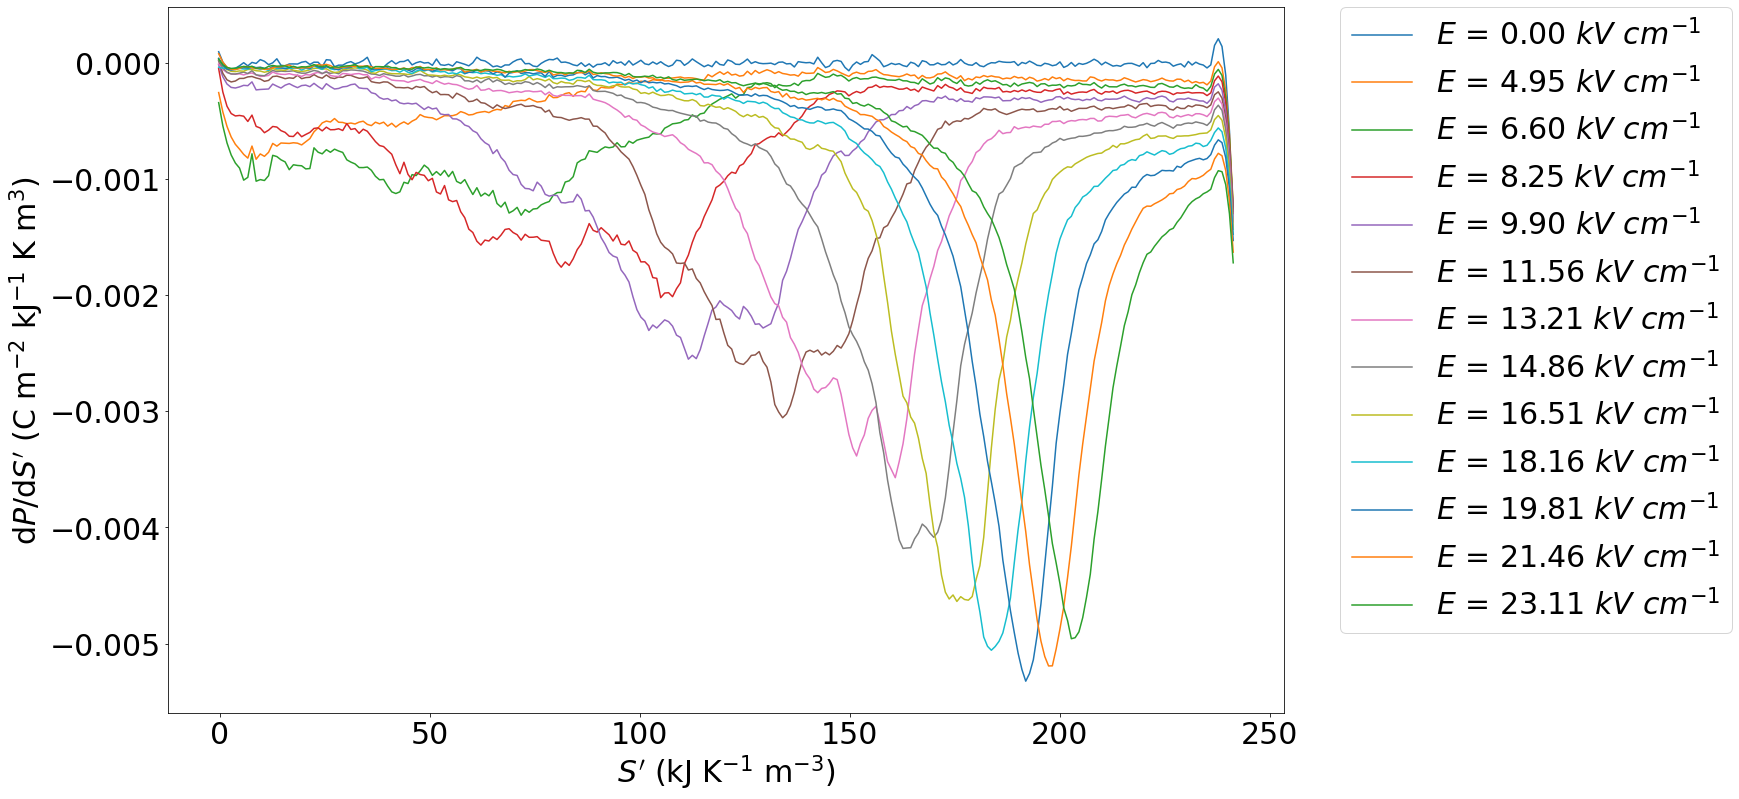

In [503]:
my_processing.plot_dP_dS_matrix(n = 20, range_start = 50, range_end=300, first = True, last = False, legend = True)

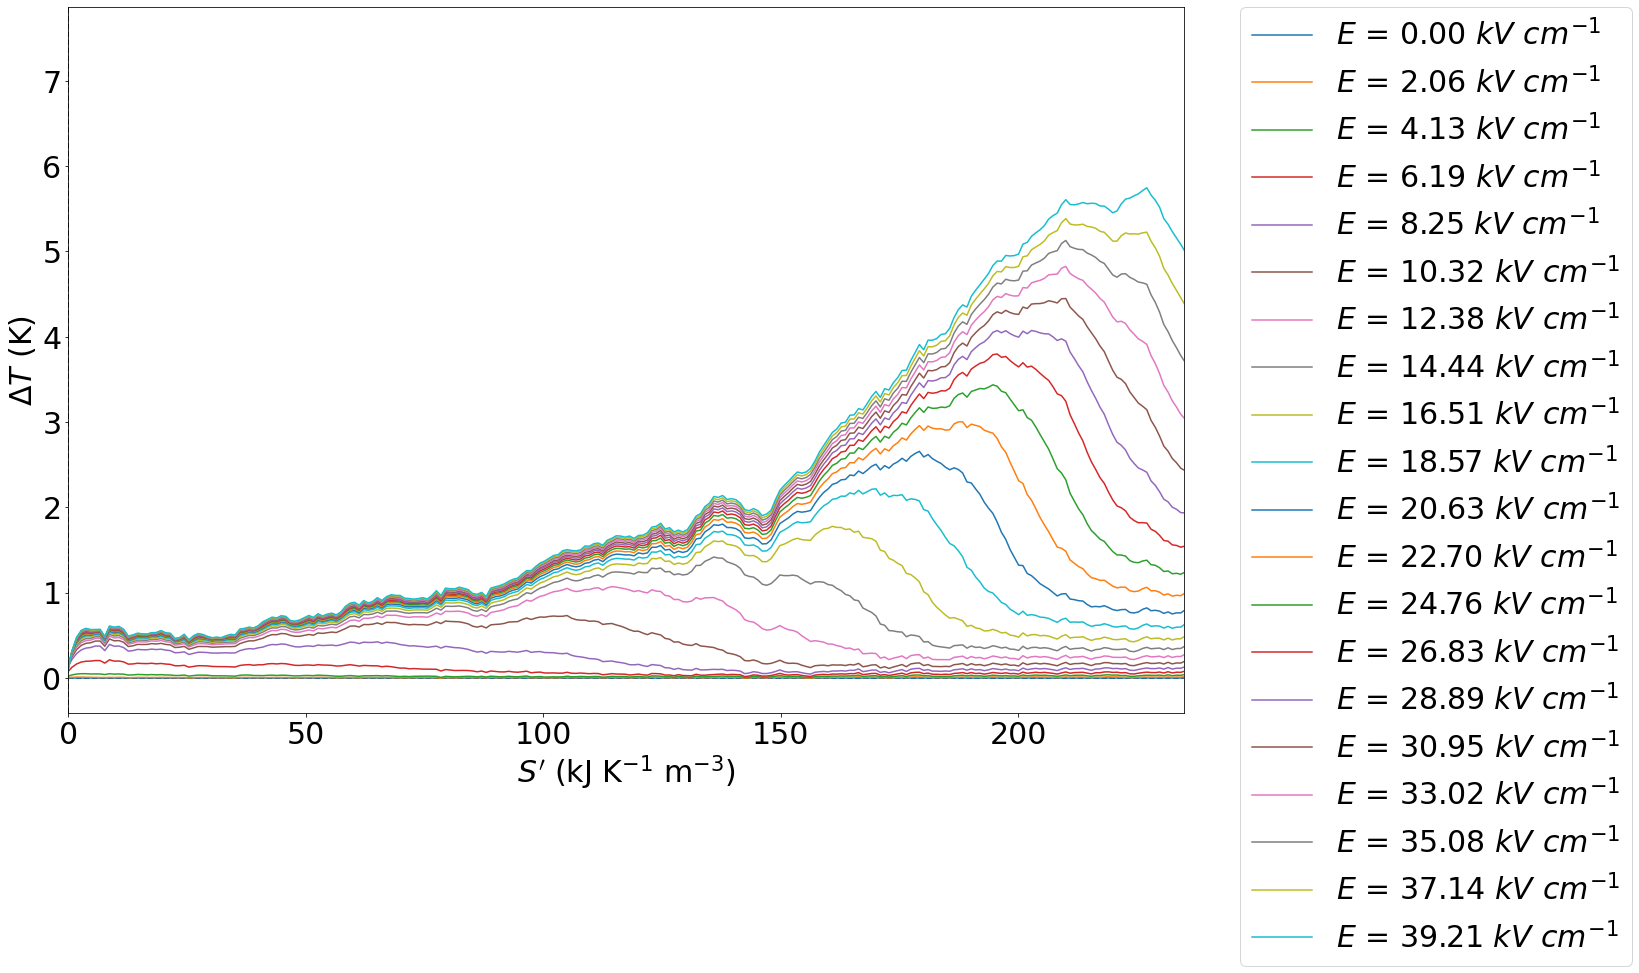

In [504]:
my_processing.plot_delta_T(n = 25, range_start = 0, range_end = 'full', first = True, last = False, legend = True, specific = [], x = 'vs_S_dash')
